# 2D-CNN for diabetic retinopathy detection

Diabetic retinopathy is the leading cause of blindness in the working-age population of the developed world. It is estimated to affect over 93 million people.
The US Center for Disease Control and Prevention estimates that 29.1 million people in the US have diabetes and the World Health Organization estimates that 347 million people have the disease worldwide. Diabetic Retinopathy (DR) is an eye disease associated with long-standing diabetes. Around 40% to 45% of Americans with diabetes have some stage of the disease. Progression to vision impairment can be slowed or averted if DR is detected in time, however this can be difficult as the disease often shows few symptoms until it is too late to provide effective treatment.
Currently, detecting DR is a time-consuming and manual process that requires a trained clinician to examine and evaluate digital color fundus photographs of the retina. By the time human readers submit their reviews, often a day or two later, the delayed results lead to lost follow up, miscommunication, and delayed treatment.
Clinicians can identify DR by the presence of lesions associated with the vascular abnormalities caused by the disease. While this approach is effective, its resource demands are high. The expertise and equipment required are often lacking in areas where the rate of diabetes in local populations is high and DR detection is most needed. As the number of individuals with diabetes continues to grow, the infrastructure needed to prevent blindness due to DR will become even more insufficient.
The need for a comprehensive and automated method of DR screening has long been recognized, and previous efforts have made good progress using image classification, pattern recognition, and machine learning. With color fundus photography as input, the goal of this homework is to push an automated detection system to the limit of what is possible – ideally resulting in models with realistic clinical potential.

### Environment Preparation

Please first follow the instruction in the pdf file.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd "drive/MyDrive/data"

/content/drive/MyDrive/data


# Introduction

In [3]:
#set all the seeds
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2
def set_seed(seed = 0):
    tf.keras.utils.set_random_seed(seed)
    print(f"Seed set to {seed}")

In [4]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model 
from tensorflow.keras.layers import Dense, Dropout, Activation, Conv2D, MaxPool2D, Flatten 
from tensorflow.keras import utils

To build a deep learning pipeline in tensorflow we will need to go over 3 steps:
- Building the dataset.
- Building the model.
- Building a custom training loop or use model.fit

# Part 1: Building the dataset

The first thing to do is to locate the path of our data. Here, our data are inside the train/val/test folder. Each of these folders contains a 0 and 1 folder with images of normal (0) and diabetic retinopathy patients (1).

In [5]:
TRAIN_PATH = "train"
TEST_PATH = "test"
VAL_PATH = "val"

Then we will ask tensorflow to store all the filenames that are in these folder in three dataset named train_ds, val_ds and test_ds

In [6]:
train_ds = tf.data.Dataset.list_files(TRAIN_PATH + "/*/*.png",shuffle = True)
val_ds = tf.data.Dataset.list_files(VAL_PATH + "/*/*.png",shuffle = False)
test_ds = tf.data.Dataset.list_files(TEST_PATH + "/*/*.png",shuffle = False)

We can count how many images have been found using the `len` function.

In [7]:
print(f"There are {len(train_ds)} images in the training set.")
print(f"There are {len(val_ds)} images in the validation set.")
print(f"There are {len(test_ds)} images in the test_ds set.")

There are 680 images in the training set.
There are 102 images in the validation set.
There are 194 images in the test_ds set.


We can access an element of a dataset using the following command:

In [8]:
next(iter(train_ds))

<tf.Tensor: shape=(), dtype=string, numpy=b'train/0/f8f5942b690e.png'>

Furthermore, we can iterate through a tensorflow dataset like this:

In [9]:
i =0
for element in train_ds:
  print(element)
  if i== 5:
    break
  i+=1

tf.Tensor(b'train/0/78937523f7a8.png', shape=(), dtype=string)
tf.Tensor(b'train/1/6735931000ec.png', shape=(), dtype=string)
tf.Tensor(b'train/1/63b4d030b016.png', shape=(), dtype=string)
tf.Tensor(b'train/0/c096131ad065.png', shape=(), dtype=string)
tf.Tensor(b'train/0/d93b61dc8f64.png', shape=(), dtype=string)
tf.Tensor(b'train/1/aa6673241154.png', shape=(), dtype=string)


As you can see the variable stored in our dataset are some tensors, which contain a string structured as follow:

dataset/diagnosis/image_name,  where 
- dataset is train, val or test.
- diagnosis is 0 or 1.
- image_name is the name of the image with the png extension.


We first need to create a parser function to help tensorflow to read our images and to know what is the corresponding label.


Lets first define a parse function. It will tell our tensorflow dataset how to read an image. Indeed, the first command line will extract the label while the two next ones will open the image. Finally, it will return the image normalized by 255 and the label.

In [10]:
def parse(image_path):
  label = tf.strings.to_number(tf.strings.split(image_path, '/')[1]) ## find the label (0 or 1) and convert it to float
  image = tf.io.read_file(image_path)
  image = tf.io.decode_png(image)
  return image/255,label


Let's apply this parsing function to our three datasets! 

We will use this parse function with the `.map` method of the tensorflow dataset API. The map function is here to tell the dataset which function to apply when reading a file. To summarize, every time the dataset will need to open one image, it will apply the parse function to the file name of the image. We use it because we have too many images and we cannot load all of them in RAM. That is why we open them only when needed.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.map(parse, num_parallel_calls = AUTOTUNE)
val_ds = val_ds.map(parse,num_parallel_calls = AUTOTUNE)
test_ds = test_ds.map(parse,num_parallel_calls = AUTOTUNE)


Now each iteration of our datasets should give us an image and a label. Let's see the use of `next(iter())`.

If the next cell fails, change the command line in `parse` from


`label = tf.strings.to_number(tf.strings.split(image_path, '/')[1]) ## find the label (0 or 1) and convert it to float`


to



`label = tf.strings.to_number(tf.strings.split(image_path, '\\')[1]) ## find the label (0 or 1) and convert it to float`

In [12]:
image,label = next(iter(train_ds))

In [13]:
image

<tf.Tensor: shape=(224, 224, 3), dtype=float32, numpy=
array([[[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       [[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ]],

       ...,

       [[0.        , 0.00392157, 0.        ],
        [0.  

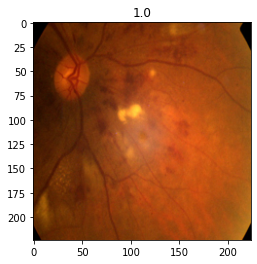

In [14]:
plt.imshow(image)
plt.title(label.numpy())
plt.show()

The last step is to create some data augmentation to make our model perfrom better.

This function should return a modified (image, label) pair, given an original (image, label) pair. We will couple this function with the `.map` function in order to read a different version of the pair (image,label) each time later on. Basically, this just means that every image that will be fed to the network will first be modified for instace by rotating and\or flipping.

In [15]:
def augmentation(image,label):
  # First we want to perform some random rotation of 0,90,180 or 270 degree. We can do it using the 
  # tf.image.rot90 function. But before, we need to randomly sample an integer between 0 and 4 (excluded) in
  # order to know which angle we want (0 <-> 0), (1<->90), (2<->180),(3<->270)
  k = tf.random.uniform(shape = [], minval = 0, maxval = 4, dtype = tf.int32)
  # ----------TODO : apply the rotation to the image using tf.image.rot90 ------------
  image = tf.image.rot90(image, k)
  #------------------------------------------------------------------------------------------




  # ----------TODO : random sample a tf.float32 between 0 and 1 and name it proba------------
  proba = tf.random.uniform(shape = [], minval = 0, maxval = 1, dtype = tf.float32)
  #--------------------------------------------------------------------------------------------

  #We want to perform some random flipping of the image using tf.image.flip_up_down with probability 0.5:
  #We now define our condition to see if the probability is lower than 0.5 which mean that we want to apply the flipping
  # or higher than 0.5 which mean we will not apply anything
  flip_cond = tf.less(proba,0.5)

  #Now we want to apply the flipping when the flip_condition is true, for this we can use the tf.cond function
  #It works like a ternary operator:
  #tf.cond(a,b,c) will return b if a == True or c if a == False
  # If the proba is lower than 0.5 return the flipped image and store it inside image, otherwise return the retated image
  image = tf.cond(flip_cond,lambda: tf.image.flip_up_down(image), lambda: image)


  return image,label

In order to apply augmentaion to the training set, we use again the `.map` as mentioned but now with `augmentation` function:

In [16]:
train_ds = train_ds.map(augmentation, num_parallel_calls = AUTOTUNE)  # notice the augmentation argument

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Now our dataset is just missing to be attributed with a batch size to be ready. This can be done with the following command:

In [17]:
BATCH_SIZE = 8
final_train_ds = train_ds.batch(BATCH_SIZE)
final_val_ds = val_ds.batch(BATCH_SIZE)
final_test_ds = test_ds.batch(BATCH_SIZE)

Notice that now the datasets are called `final_ds`.

# Part 2: Building the model

In this part you will have to build a 2D CNN using tensorflow. Complete the `build_model` function that should return your compiled model. Its' input size should be the same as our data (ie (224,224,3)). Notice that 3 on the right represents the channels (R,G,B). In general the dimension of images are $(B,H,W,C)$ meaning (the number of images per batch, image's number of rows,image's number of columns, number of channels).

Please use a ReLU activation for each of your Linear or Convolutional layer except the last one which should use a sigmoid activation.

Use $3X3$ kernel size for convolution layers and $(2,2)$ maxpooling size. Build 4 convolutional layers and two dense layers where the second one is with the size of 1 and sigmoid activation. For number of kernels in each convolutional layer and\or the number of neurons in the linear layer you may use `wandb`.

Please compile it within `build_model` using an adam optimizer with a learning rate of 1e-3 and a crossentropy loss with `reduction = 'none'` and the accuracy as metric. Please make sure there is no sigmoid included inside your loss function (`from_logit` argument) because we already included it in the model definition. 

In [18]:
def build_model():
  #----------- Implement your code here:-------------------------------------------------------------------- 
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224,224,3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    bce=tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='none')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'], loss=bce)
  #------------------------------------------------------------------------------------------------------
    return model

In [19]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

# Part 3: Keras model.fit to train your model

Use `model.fit` to train your model. Since we are using tensorflow datasets, you will not need to specify x and y but only `final_train_ds`. You will also not need to specify a batch size because it is already included in our dataset above.
Please only specify validation_data = final_val_ds, and epochs = 10. Train the model with `fit` method:

In [20]:
set_seed() 
model = build_model()
  #----------- Implement your code here:-------------------------------------------------------------------- 
model.fit(final_train_ds, validation_data=final_val_ds, epochs=10)
  #------------------------------------------------------------------------------------------------------

Seed set to 0
Epoch 1/10
85/85 [==============================] - 55s 486ms/step - loss: 0.6394 - accuracy: 0.6118 - val_loss: 0.4089 - val_accuracy: 0.7745
Epoch 2/10
85/85 [==============================] - 3s 32ms/step - loss: 0.2945 - accuracy: 0.8500 - val_loss: 0.2047 - val_accuracy: 0.8824
Epoch 3/10
85/85 [==============================] - 6s 72ms/step - loss: 0.2675 - accuracy: 0.8897 - val_loss: 0.1791 - val_accuracy: 0.9216
Epoch 4/10
85/85 [==============================] - 3s 33ms/step - loss: 0.2386 - accuracy: 0.9059 - val_loss: 0.1474 - val_accuracy: 0.9608
Epoch 5/10
85/85 [==============================] - 3s 40ms/step - loss: 0.2052 - accuracy: 0.9265 - val_loss: 0.1611 - val_accuracy: 0.9216
Epoch 6/10
85/85 [==============================] - 3s 37ms/step - loss: 0.2065 - accuracy: 0.9221 - val_loss: 0.1818 - val_accuracy: 0.8824
Epoch 7/10
85/85 [==============================] - 4s 43ms/step - loss: 0.1956 - accuracy: 0.9265 - val_loss: 0.1627 - val_accuracy: 0.92

Evaluate your model on the final_test_ds, using model.evaluate.

In [21]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
loss, acc = model.evaluate(final_test_ds)
print("Loss:", loss)
print("Accuracy score:", acc)
  #------------------------------------------------------------------------------------------------------

25/25 [==============================] - 15s 604ms/step - loss: 0.2049 - accuracy: 0.9227
Loss: 0.20485419034957886
Accuracy score: 0.9226804375648499


Now we want to plot the confusion matrix of our model. The simplest way would be first to have a test dataset with a batch size of 1. We can build it here:

In [22]:
one_size_test_ds = test_ds.batch(1)

Then, we need to iterate through our dataset, store the labels inside `y_true` list. Right after that, you will need to store the prediction inside `y_pred` list.

Complete the following loop. Append the true label for each example to `y_true` and every predicted probability to `y_pred` using the trained model. Don't forget to use `.numpy().item()` for the labels and predictions. When estimating the probability using the model, set `training=False`.

In [23]:
y_true = []
y_pred = []

for image,label in tqdm(one_size_test_ds):
  #----------- Implement your code here:-------------------------------------------------------------------- 
    y_true.append(label.numpy().item())
    pred = model(image, training=False)
    y_pred.append(pred.numpy().item())
  #------------------------------------------------------------------------------------------------------

  0%|          | 0/194 [00:00<?, ?it/s]

For more flexibility,  convert the lists `y_true` and `y_pred` into numpy array:

In [24]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
y_true = np.array(y_true)
y_pred = np.array(y_pred)
  #------------------------------------------------------------------------------------------------------

In [25]:
print(f" y_true: {y_true}")
print(f"We have extracted the following predictions: {y_pred}")

 y_true: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
We have extracted the following predictions: [2.50355747e-12 3.01105917e-01 4.28612605e-02 5.15599874e-09
 6.25030041e-01 6.58657312e-01 2.85739359e-02 1.55496731e-01
 8.70086253e-02 3.79278475e-09 1.57183308e-10 5.86542189e-02
 4.79547605e-02 1.26585647e-01 9.98018861e-01 4.85585295e-02
 5.19131538e-09 1.87653504e-11 1.07995294e-01 1.63475111e-09
 3.15841399e-02 2.47661881e-02 2.25954450e-10 2.8

As you can see, our `y_pred` are the probability of being sick estimated by the net's weights and the final sigmoid. Apply a threshold of 0.5 which will label the predictions. If the probability will be higher than the threshold then the predicted label will be 1 and 0 otherwise. This function have to be written in a single line.

In [26]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
y_pred = np.where(y_pred > 0.5, 1, 0)
  #------------------------------------------------------------------------------------------------------

In [27]:
print(f"We have extracted the following y_true: {y_true}")
print(f"We have extracted the following y_pred: {y_pred}")

We have extracted the following y_true: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1.]
We have extracted the following y_pred: [0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 0 1 1 1 1 1 1

Now you need to compute the accuracy between `y_true` and `y_pred` from scratch (without using any other library than numpy). You have to do this in one line using `np.mean()`. Print it

In [28]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
accuracy = np.mean(y_pred==y_true)
print(f' Accuracy is: {accuracy}')
  #------------------------------------------------------------------------------------------------------

 Accuracy is: 0.9226804123711341


Let's plot the confusion matrix using sklearn:

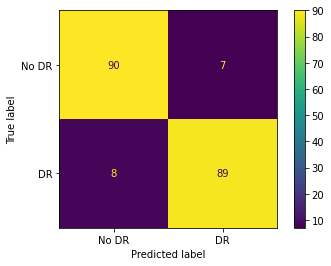

In [29]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No DR","DR"])
disp.plot()


# Part 4: training the model with a customed training loop

Rebuild your model to reinitialize the weights:

In [48]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
model = build_model()
bce=tf.keras.losses.BinaryCrossentropy(from_logits=False, reduction='sum_over_batch_size')
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), metrics=['accuracy'], loss=bce)
  #------------------------------------------------------------------------------------------------------

Now you will need to fill the following `train_step` function. This function takes one batch of images `x`, and one batch of labels `y`. It feeds the `x` into the model, compute the loss function on this batch, then perform the gradient descent and return the updated loss function.

In [49]:
@tf.function
def train_step(x,y,model):
  y = tf.reshape(y,(-1,1))
  with tf.GradientTape() as tape:
    ##------------TO DO pred = the prediction of the model on x and the loss.
    pred = model(x, training=True)
    loss = model.compiled_loss(y, pred)
    ##-----------------------------------------------------------------------------------------------------
  #The two following lines make the update of the gradient descent
  grads = tape.gradient(loss, model.trainable_weights)
  model.optimizer.apply_gradients(zip(grads, model.trainable_weights))
  accuracy = tf.cast(tf.round(pred) == y,tf.int32)  # division by the number of examples will take place later on
  return loss, accuracy

You will also need to implement validation by `val_step` function. This function takes one batch of images `x` and one batch of labels `y` and returns the loss function without performing any gradient descent.

In [50]:
@tf.function
def val_step(x,y,model):
  y = tf.reshape(y,(-1,1))
  ##------------TO DO pred = the prediction of the model on x and the loss.
  pred = model(x, training=False)
  loss = model.compiled_loss(y, pred)
  #-----------------------------------------------------------------------------------
  accuracy = tf.cast(tf.round(pred) == y,tf.int32)  # division by the number of examples will take place later on
  return loss,accuracy

Train your model:

In [51]:
epochs = 10
for epoch in range(epochs):
  epoch_loss = 0
  epoch_accuracy = 0
  n=0
  for image, label in (pbar := tqdm(final_train_ds)):
    ##------------TO DO perform the train step on image and label, store the output in a variable named loss.
    train_batch_loss, accuracy = train_step(image, label, model)
    epoch_loss += train_batch_loss*BATCH_SIZE
    epoch_accuracy += tf.reduce_mean(accuracy)
    n+=1
    ##---------------------------------------------------------------------------------------------------
    pbar.set_description("Train Epoch number : {}, loss = {}, accuracy = {}".format(epoch,epoch_loss/n,epoch_accuracy/n))

  epoch_val_loss = 0
  n=0
  epoch_val_accuracy = 0
  ##### Perform the validation step
  for image,label in (pbar := tqdm(final_val_ds)):
    ##------------TO DO perform the val step on image and label, store the output in a variable named val_loss.
    val_batch_loss, accuracy = val_step(image, label, model)
    epoch_val_loss += val_batch_loss*BATCH_SIZE
    epoch_val_accuracy += tf.reduce_mean(accuracy)
    n+=1
    ##------------------------------------------------------------------------------------------------
    pbar.set_description("Val Epoch number : {}, loss = {}, accuracy {}".format(epoch,epoch_val_loss/n, epoch_val_accuracy/n))


  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/85 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

For the predictions and the labels, apply the same as several cells before.

In [52]:
y_true = []
y_pred = []

for image,label in tqdm(one_size_test_ds):
  #----------- Implement your code here:-------------------------------------------------------------------- 
    y_true.append(label.numpy().item())
    pred = model(image, training=False)
    y_pred.append(pred.numpy().item())
  #------------------------------------------------------------------------------------------------------

  0%|          | 0/194 [00:00<?, ?it/s]

Convert into numpy, label the prediction using threshold of 0.5 and print the accuracy:

In [53]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = np.mean(y_true == y_pred)
print(f' Accuracy is: {accuracy}')
  #------------------------------------------------------------------------------------------------------

 Accuracy is: 0.9175257731958762


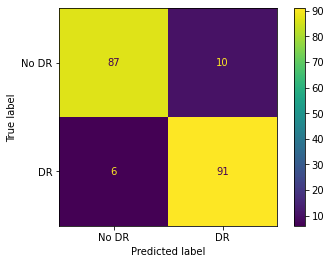

In [54]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

cm = confusion_matrix(y_true,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No DR","DR"])
disp.plot()


# Qualitative results:

We will now take 20 images from the shuffeled testset and evaluate the performance:

0it [00:00, ?it/s]

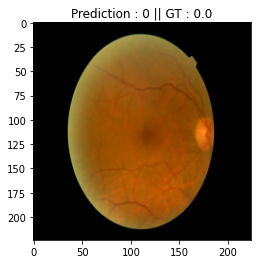

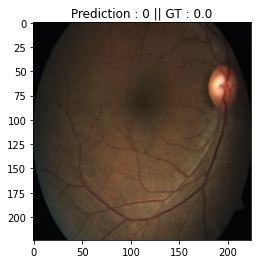

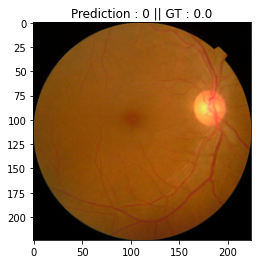

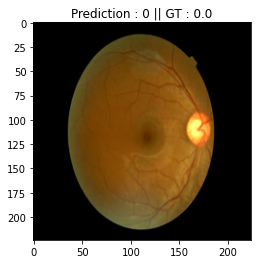

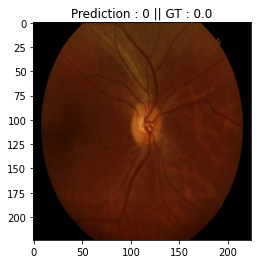

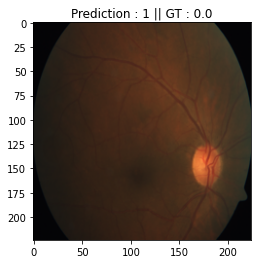

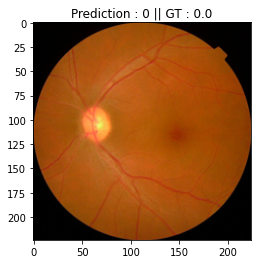

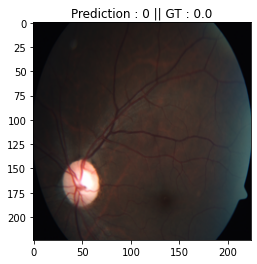

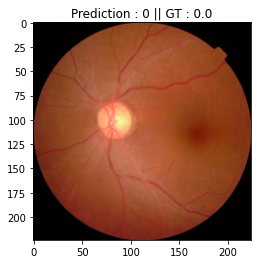

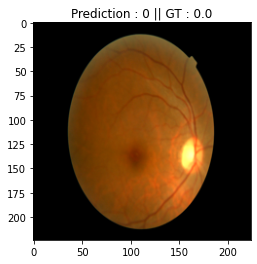

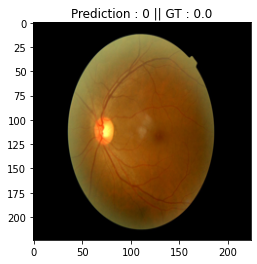

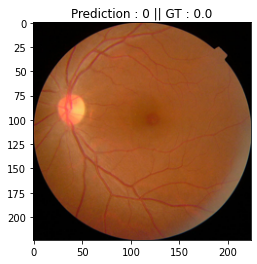

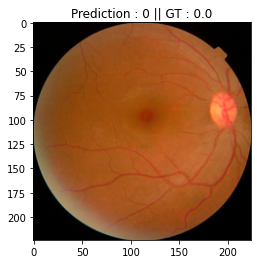

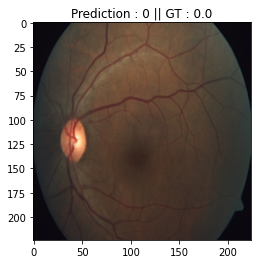

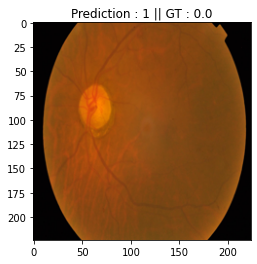

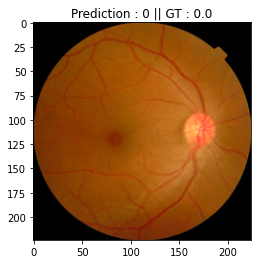

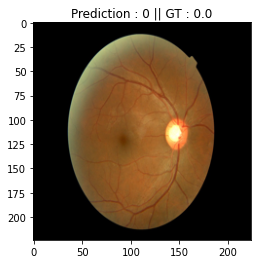

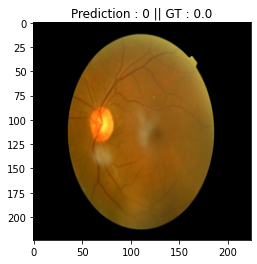

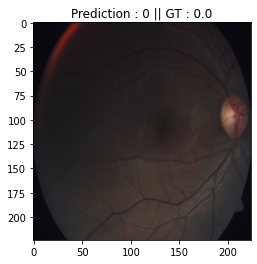

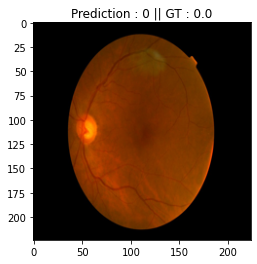

In [37]:
n = 0
for (x,y_true), curr_y_pred in tqdm(zip(one_size_test_ds, y_pred)):
    plt.imshow(x[0])
    plt.title(f"Prediction : {curr_y_pred} || GT : {y_true.numpy().item()}")
    plt.show()
    n+=1
    if n>= 20:
        break

You should have quite good results as expected from the measured accuracy. Write a function for error analysis that will find and plot the images that the model failed to predict correctly. Can you tell by at least some of the images why it failed?


In [38]:
def error_analysis(one_size_test_ds):
  for (x,y_true), curr_y_pred in tqdm(zip(one_size_test_ds, y_pred)):
  #----------- Implement your code here:-----------------------------------------------------------------
    if (curr_y_pred!=y_true):
      plt.imshow(x[0])
      plt.title(f"Prediction : {curr_y_pred} || GT : {y_true.numpy().item()}")
      plt.show()
  #------------------------------------------------------------------------------------------------------

0it [00:00, ?it/s]

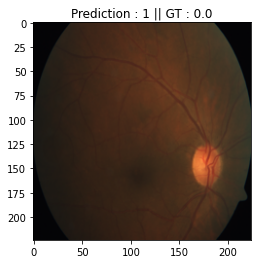

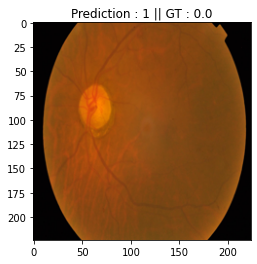

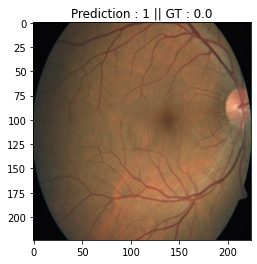

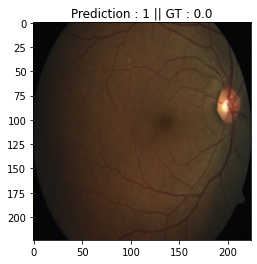

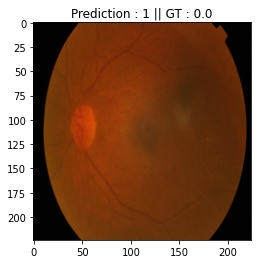

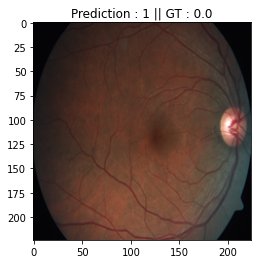

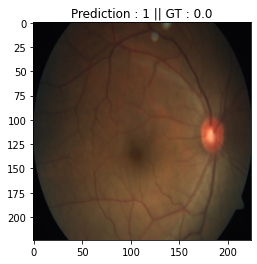

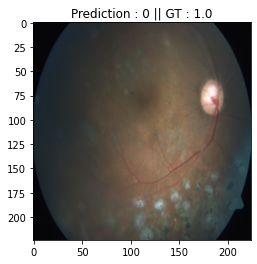

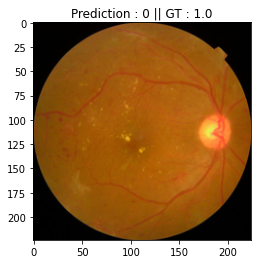

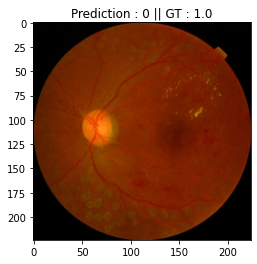

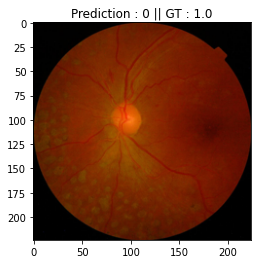

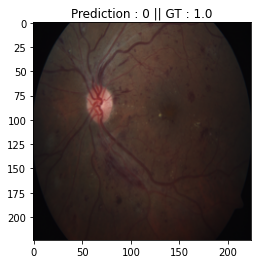

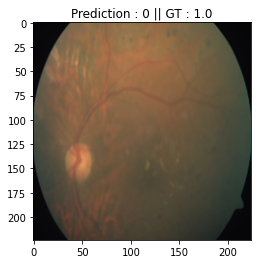

In [39]:
error_analysis(one_size_test_ds)

*It's hard to tell why some of these images failed, because we can't really know which features were extracted from the CNN. But, looking on the 'DR'-labeled images, it looks like there are some stains on the image. The model might've interperted other artifacts in the images that looks maybe a bit similar to those stains mentioned as indicators of a 'DR' labeled image.*

Let's say that for some reason, you decide that it is more important to never miss any DR patient. This means that we want our false negative number to be 0, even if it make some false positive patient being 1.
What can control these rates once the model alreday trained? Change the parmeter that controls these rates and plot the confusion matrix that has minimal FNR.

  0%|          | 0/194 [00:00<?, ?it/s]

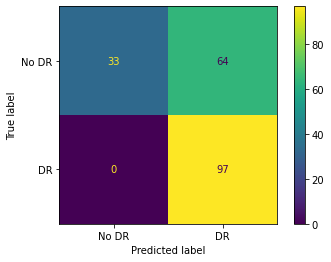

In [58]:
  #----------- Implement your code here:-------------------------------------------------------------------- 
y_true = []
y_pred = []

for image,label in tqdm(one_size_test_ds):

    y_true.append(label.numpy().item())
    pred = model(image, training=False)
    y_pred.append(pred.numpy().item())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred = np.where(y_pred > 0.01, 1, 0)
cm = confusion_matrix(y_true,y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["No DR","DR"])
disp.plot()
  #------------------------------------------------------------------------------------------------------

*The parameter we changed is the threshold. The threshold decides the boundary probability such that above it the model predicts the sample as a 'DR' label. In this task we wanted to minimize the False-Negative values, which means we want to make sure that every 'DR'-labeled sample will be truly predicted as one, even if it means we will have a lot of False-Positive predicions as an outcome. To do that, we massively reduced the boundary probability value such that even for the slightest chance a sample will be predicted as 'DR'. We can see that we also got a lot of False-Positive values (even more than True-Negative values) as an outcome, but we have 0 False-Negative values.*

GOOD LUCK!